### Prediction Stock BRI data with SVR, ANN, LSTM

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import math


matplotlib.use('Agg')
%matplotlib inline
np.random.seed(11)

In [2]:
df = pd.read_csv('data/bbri.csv', usecols=[0,4]);

In [3]:
df = df.set_index('Date')
df

,Close
Date,
2020-01-20,4660.0
2020-01-21,4670.0
2020-01-22,4710.0
2020-01-23,4740.0
2020-01-24,4740.0
...,...
2020-11-09,3690.0
2020-11-10,4000.0
2020-11-11,4120.0


In [4]:
df['pred'] = df.Close.shift(-1)

In [5]:
df

,Close,pred
Date,,
2020-01-20,4660.0,4670.0
2020-01-21,4670.0,4710.0
2020-01-22,4710.0,4740.0
2020-01-23,4740.0,4740.0
2020-01-24,4740.0,4650.0
...,...,...
2020-11-09,3690.0,4000.0
2020-11-10,4000.0,4120.0
2020-11-11,4120.0,3950.0


In [6]:
df_new = df.dropna()

In [7]:
df.describe()

,Close,pred
count,200.000000,199.000000
mean,3360.200000,3353.668342
std,611.595623,606.104560
min,2170.000000,2170.000000
25%,3030.000000,3030.000000
50%,3160.000000,3160.000000
75%,3617.500000,3610.000000
max,4740.000000,4740.000000


### convert data to float

In [8]:
values = df_new.values
values = values.astype('float32')
len(values)
df_new['Close'].values

array([4660., 4670., 4710., 4740., 4740., 4650., 4620., 4620., 4580.,
       4460., 4460., 4560., 4560., 4550., 4550., 4500., 4510., 4530.,
       4570., 4550., 4470., 4400., 4480., 4560., 4510., 4490., 4500.,
       4480., 4130., 4190., 3980., 4100., 4220., 4150., 4010., 3750.,
       3910., 3910., 3610., 3720., 3500., 3260., 3140., 2930., 2810.,
       2620., 2440., 2940., 3230., 3010., 3020., 2930., 2870., 2890.,
       3020., 3030., 2820., 2790., 2770., 2900., 2760., 2610., 2830.,
       2780., 2720., 2790., 2800., 2630., 2660., 2590., 2580., 2730.,
       2630., 2630., 2620., 2590., 2620., 2490., 2470., 2350., 2240.,
       2170., 2370., 2480., 2520., 2630., 2730., 2950., 3180., 3100.,
       3060., 3110., 3300., 3210., 3030., 2970., 3030., 2900., 3130.,
       3100., 3050., 3100., 3060., 3010., 3120., 3060., 3030., 3040.,
       3030., 3060., 3060., 3050., 3040., 3030., 3190., 3140., 3110.,
       3160., 3170., 3130., 3140., 3100., 3050., 3150., 3100., 3140.,
       3090., 3150.,

In [9]:
print("Min:",np.min(values))
print("Max:",np.max(values))

Min: 2170.0
Max: 4740.0


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(values)
scaled = pd.DataFrame(scaled)


X = np.array(scaled[0])
y = np.array(scaled[1])

print(len(X.reshape(-1,1)), len(X))

199 199


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1),y, test_size=0.2, random_state=True)

### Without Scaled Data
# X_train, X_test, y_train, y_test = train_test_split(df_new['Close'].values.reshape(-1,1),df_new['pred'].values, test_size=0.2, random_state=True)
y_train.shape

(159,)

In [12]:
def model(type):
    
    if type == 'svm':
        models = SVR(kernel='rbf', C=1e3, gamma=0.1)
    elif type == 'ann':
        models = Sequential()
        models.add(Dense(10, input_dim=1, activation='relu', use_bias=True, bias_initializer='ones')) #inisialisasi input layer dan hidden layer
        models.add(Dense(10, activation='relu', use_bias=True, bias_initializer='ones')) #hidden layer 2
        models.add(Dense(1, activation='relu')) #inisialisasi output layer
        models.compile(loss='mean_squared_error', optimizer='adam')
        models.summary()
    elif type == 'lstm':
        models = Sequential()
        models.add(LSTM(units=4,return_sequences=True, input_shape=(1,1)))
        models.add(Dropout(0.2))
        
        models.add(LSTM(units=4))
        models.add(Dropout(0.2))
        
        models.add(Dense(1))
        models.compile(loss='mean_squared_error', optimizer='adam')
        models.summary()
    return models

In [20]:
def plot_forecast(dataset,train, test, model, plotName):
    # plotting train data
    trainPredictPlot = np.zeros(shape=(len(train)+1,1))
    trainPredictPlot = [ i[0] for i in train]
    trainPredictPlot = [np.nan]+trainPredictPlot
    
    testPredictPlot = [np.nan for i in trainPredictPlot]+[ i[0] for i in test]

    # Show Plot
    plt.title(plotName)
    plt.plot(dataset)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.savefig('output/{}_graph.png'.format(model))
    plt.show()

### SVM Model

In [21]:
svm = model('svm')

In [22]:
svm.fit(X_train,y_train)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [23]:
svm_confidence = svm.score(X_test, y_test)
print("svm confidence: ", svm_confidence)

svm confidence:  0.9426214772626347


In [24]:
y_pred_svm = svm.predict(X_test)

y_pred_svm = np.reshape(y_pred_svm,(len(y_pred_svm),1))

yPredTemp = np.zeros(shape=(len(y_pred_svm), 2))
yPredTemp[:,0] = y_pred_svm[:,0]
y_pred_svm_decode = scaler.inverse_transform(yPredTemp)[:,0]


trainPredictSvm = svm.predict(X_train)
trainPredictSvm = np.reshape(trainPredictSvm,(len(trainPredictSvm),1))

trainPredTempSvm = np.zeros(shape=(len(trainPredictSvm), 2))
trainPredTempSvm[:,0] = trainPredictSvm[:,0]
trainPredictSvm_decode = scaler.inverse_transform(trainPredTempSvm)[:,0]

In [25]:
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)

print('Test Score: %.3f MSE (%.3f RMSE) SVM' % (mse_svm, rmse_svm))

Test Score: 0.003 MSE (0.052 RMSE) SVM


#### plot SVM model

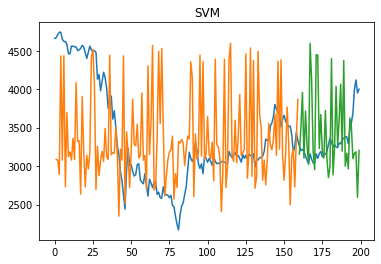

In [26]:
plot_forecast(df['Close'].values, trainPredictSvm_decode.reshape(-1,1),y_pred_svm_decode.reshape(-1,1),'svm','SVM')

### ANN Model

In [44]:
ann = model('ann')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                20        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [45]:
# history_ann = ann.fit(X_train, y_train, epochs = 10, batch_size=32,
#                          validation_data=(X_test,y_test),
#                          verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)
history_ann = ann.fit(X_train,y_train, epochs=10,
                      batch_size=1,
                      validation_data=(X_test,y_test),
                      verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)], shuffle=False)

Epoch 1/10
159/159 [==============================] - 0s 937us/step - loss: 0.0870 - val_loss: 0.0530
Epoch 2/10
159/159 [==============================] - 0s 884us/step - loss: 0.0502 - val_loss: 0.0299
Epoch 3/10
159/159 [==============================] - 0s 849us/step - loss: 0.0274 - val_loss: 0.0153
Epoch 4/10
159/159 [==============================] - 0s 849us/step - loss: 0.0135 - val_loss: 0.0071
Epoch 5/10
159/159 [==============================] - 0s 823us/step - loss: 0.0062 - val_loss: 0.0036
Epoch 6/10
159/159 [==============================] - 0s 821us/step - loss: 0.0033 - val_loss: 0.0026
Epoch 7/10
159/159 [==============================] - 0s 785us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 8/10
159/159 [==============================] - 0s 820us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 9/10
159/159 [==============================] - 0s 999us/step - loss: 0.0024 - val_loss: 0.0026
Epoch 10/10
159/159 [==============================] - 0s 1ms/step - loss: 0.0025 

In [46]:
trainScoreAnn = ann.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.3f MSE (%.3f RMSE) ANN' % (trainScoreAnn, math.sqrt(trainScoreAnn)))

testScoreAnn = ann.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.3f MSE (%.3f RMSE) ANN' % (testScoreAnn, math.sqrt(testScoreAnn)))

Train Score: 0.002 MSE (0.042 RMSE) ANN
Test Score: 0.003 MSE (0.052 RMSE) ANN


In [47]:
trainPredictAnn = ann.predict(X_train)
testPredictAnn = ann.predict(X_test)

trainPredictTempAnn = np.zeros(shape=(len(trainPredictAnn), 2))
trainPredictTempAnn[:,0] = trainPredictAnn[:,0]
trainPredictAnn = scaler.inverse_transform(trainPredictTempAnn)[:,0]


testPredictTempAnn = np.zeros(shape=(len(testPredictAnn), 2))
testPredictTempAnn[:,0] = testPredictAnn[:,0]
testPredictAnn = scaler.inverse_transform(testPredictTempAnn)[:,0]

In [48]:
def save_history(history,model,name):
            
    # save history
    loss_history = history.history["loss"]
    testing_loss_history = history.history["val_loss"]

    loss = np.array(loss_history)
    np.savetxt("output/loss_history_{}.txt".format(name), loss, delimiter=",")

    tes_loss = np.array(testing_loss_history)
    np.savetxt("output/testing_loss_history_{}.txt".format(name), tes_loss, delimiter=",")

    model_json = model.to_json()
    with open("output/model_{}.json".format(name), "w") as json_file:
        json_file.write(model_json)

    model.save_weights('output/model_{}.h5'.format(name))
    
    return 'loss history {} dan model {} saved!'.format(name,name)

In [49]:
save_history(history_ann,ann,'ann')

'loss history ann dan model ann saved!'

#### plot Ann model

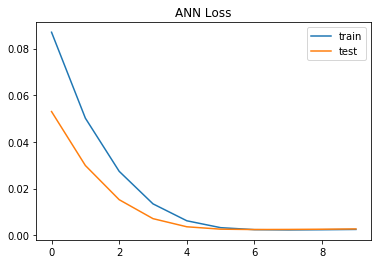

In [50]:
plt.title('ANN Loss')
plt.plot(history_ann.history['loss'],label='train')
plt.plot(history_ann.history['val_loss'],label='test')
plt.legend()
plt.savefig('output/ann_loss.png')
plt.show()

### LSTM Model

In [51]:
lstm = model('lstm')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 4)              96        
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 4)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [52]:
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
X_train.shape,X_test.shape

((159, 1, 1), (40, 1, 1))

In [53]:
history_lstm = lstm.fit(X_train,y_train, epochs=10,
                      batch_size=1,
                      validation_data=(X_test,y_test),
                      verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)

Epoch 1/10
159/159 [==============================] - 1s 5ms/step - loss: 0.1348 - val_loss: 0.0671
Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0330
Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0283
Epoch 4/10
159/159 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0247
Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0206
Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0163
Epoch 7/10
159/159 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0129
Epoch 8/10
159/159 [==============================] - 0s 2ms/step - loss: 0.0198 - val_loss: 0.0102
Epoch 9/10
159/159 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0075
Epoch 10/10
159/159 [==============================] - 0s 2ms/step - loss: 0.0179 - val_loss: 0.0048

In [54]:
trainScoreLstm = lstm.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.3f MSE (%.3f RMSE) LSTM' % (trainScoreLstm, math.sqrt(trainScoreLstm)))

testScoreLstm = lstm.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.3f MSE (%.3f RMSE) LSTM' % (testScoreLstm, math.sqrt(testScoreLstm)))

trainScoreLstm = trainScoreLstm
testScoreLstm = testScoreLstm
rmseTrain = math.sqrt(trainScoreLstm)
rmseTest = math.sqrt(testScoreLstm)
score = np.array([trainScoreLstm,testScoreLstm,rmseTrain,rmseTest])
np.savetxt("output/score_lstm.txt",score, delimiter=";")


Train Score: 0.005 MSE (0.073 RMSE) LSTM
Test Score: 0.005 MSE (0.070 RMSE) LSTM


In [55]:
save_history(history_lstm,lstm,'lstm')

'loss history lstm dan model lstm saved!'

#### plot LSTM model

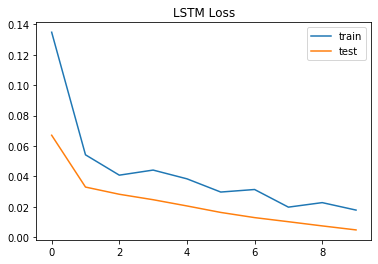

In [56]:
plt.title('LSTM Loss')
plt.plot(history_lstm.history['loss'],label='train')
plt.plot(history_lstm.history['val_loss'],label='test')
plt.legend()
plt.savefig('output/lstm_loss.png')
plt.show()

In [57]:
trainPredictLstm = lstm.predict(X_train)
testPredictLstm = lstm.predict(X_test)

trainPredictTempLstm = np.zeros(shape=(len(trainPredictLstm), 2))
trainPredictTempLstm[:,0] = trainPredictLstm[:,0]
trainPredictLstm = scaler.inverse_transform(trainPredictTempLstm)[:,0]


testPredictTempLstm = np.zeros(shape=(len(testPredictLstm), 2))
testPredictTempLstm[:,0] = testPredictLstm[:,0]
testPredictLstm = scaler.inverse_transform(testPredictTempLstm)[:,0]


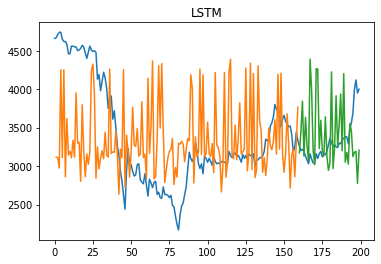

In [58]:
plot_forecast(df['Close'].values,trainPredictLstm.reshape(-1,1),testPredictLstm.reshape(-1,1),'lstm','LSTM')

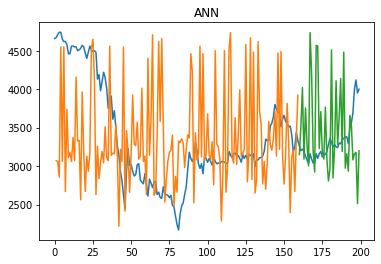

In [59]:
plot_forecast(df['Close'].values,trainPredictAnn.reshape(-1,1),testPredictAnn.reshape(-1,1),'ann','ANN')